In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import utils

country_aggregated_df = pd.read_csv('./Data/Gas_Trade_Flows_IEA_202310 - Data.csv')

### Process data

In [2]:
# Remove unnamed colum
country_aggregated_df = country_aggregated_df.drop(columns=['Unnamed: 2'])

# Remove the columns with flow data beteen Oct-08 and Aug-09
country_aggregated_df = country_aggregated_df.drop(columns=['Oct-08', 'Nov-08', 'Dec-08', 'Jan-09', 'Feb-09', 'Mar-09', 'Apr-09', 'May-09', 'Jun-09', 'Jul-09', 'Aug-09', 'Sep-09', 'Oct-09', 'Nov-09', 'Dec-09'])
country_aggregated_df.head()

,Borderpoint,Exit,Entry,MAXFLOW (Mm3/h),Jan-10,Feb-10,Mar-10,Apr-10,May-10,Jun-10,...,Jan-23,Feb-23,Mar-23,Apr-23,May-23,Jun-23,Jul-23,Aug-23,Sep-23,Oct-23
0,Adriatic LNG,Liquefied Natural Gas,Italy,1.10,602,581,657,622,608,439,...,687.0,654.0,850.0,714.0,809.0,620.0,823.0,693.0,754.0,745.0
1,Almeria,Algeria,Spain,1.07,0,0,0,0,0,0,...,760.0,659.0,569.0,619.0,698.0,448.0,767.0,696.0,709.0,863.0
2,Alveringem,Belgium,France,NaN,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alveringem,France,Belgium,0.37,0,0,0,0,0,0,...,644.0,616.0,185.0,240.0,392.0,396.0,195.0,50.0,394.0,371.0
4,Badajoz,Portugal,Spain,0.30,5,4,2,0,0,0,...,54.0,0.0,4.0,91.0,139.0,84.0,44.0,25.0,19.0,27.0


In [3]:
country_aggregated_df.shape

(228, 170)

### Countries in the data

In [4]:
unique_countries = set(country_aggregated_df['Exit'].unique()) | set(country_aggregated_df['Entry'].unique())

print("Data contains {} unique countries".format(len(unique_countries)))
print(unique_countries)


Data contains 45 unique countries
{'Netherlands', 'Norway', 'Italy', 'North Macedonia', 'Sweden', 'Hungary', 'Czech Republic', 'Algeria', 'Lithuania', 'Moldova', 'Russia', 'Not Elsewhere Specified', 'France', 'Libya', 'Isle of Man', 'Estonia', 'Croatia', 'Denmark', 'United Kingdom', 'Bulgaria', 'Georgia', 'Albania', 'Slovenia', 'Liquefied Natural Gas', 'Belgium', 'Austria', 'Luxembourg', 'Germany', 'Spain', 'Romania', 'Ireland', 'Greece', 'Belarus', 'Morocco', 'Slovak Republic', 'Iran', 'Poland', 'Serbia', 'Finland', 'Latvia', 'Switzerland', 'Republic of Türkiye', 'Tunisia', 'Portugal', 'Ukraine'}


In [5]:
print("Pure exporting countries: {}".format(set(country_aggregated_df['Exit'].unique()) - set(country_aggregated_df['Entry'].unique())))
print("Pure importing countries: {}".format(set(country_aggregated_df['Entry'].unique()) - set(country_aggregated_df['Exit'].unique())))

Pure exporting countries: {'Georgia', 'Iran', 'Not Elsewhere Specified', 'Algeria', 'Belarus', 'Libya'}
Pure importing countries: {'Isle of Man', 'Sweden', 'Luxembourg', 'Ireland', 'Moldova'}


In [6]:
# Retrieve columns with flow data 
mm_yyyy = country_aggregated_df.iloc[:,country_aggregated_df.columns.get_loc('Jan-10'):]

## Test configure grid for max-flow

In [7]:
graphs = utils.create_graphs_from_dataset(country_aggregated_df)

In [8]:
# Get most recent grid
oct_23 = graphs[-1]

In [9]:
# Display edge data
oct_23_edges = utils.get_edge_data(oct_23)
oct_23_edges

,Source,Target,Borderpoint,Max Flow,Flow
0,Liquefied Natural Gas,Italy,Adriatic LNG,818.40,745.0
1,Liquefied Natural Gas,Italy,Livorno,468.72,203.0
2,Liquefied Natural Gas,Italy,Panigaglia,401.76,69.0
3,Liquefied Natural Gas,Italy,Piombino,372.00,198.0
4,Liquefied Natural Gas,Spain,Barcelona,1450.80,320.0
...,...,...,...,...,...
222,Belarus,Lithuania,Kotlovka,967.20,240.0
223,Belarus,Lithuania,Privalka,32.00,32.0
224,Not Elsewhere Specified,Ukraine,Not Elsewhere Specified,6161.00,0.0
225,Morocco,Spain,Tarifa,1220.16,0.0


In [10]:
# Display node data
oct_23_nodes = utils.get_node_data(oct_23)
oct_23_nodes

,Country,Total Demand,Summer Demand,Winter Demand,Max Production,Storage Deliverability,Storage Injection,Storage WGV,LNG Send-out,LNG Storage,Power Generation
0,Liquefied Natural Gas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Italy,718.480,271.875,394.777,95.000,2.916,1.699,195.844,707.000,617.000,44.215
2,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Spain,359.621,164.811,175.911,4.000,241.000,167.000,34.090,1.940,3.317,29.903
4,Belgium,154.113,60.583,81.648,NaN,170.000,88.000,9.130,669.000,566.000,6.915
5,France,429.707,138.442,276.604,24.000,2.488,1.131,134.351,1.358,1.340,12.893
6,Portugal,59.894,30.338,26.516,NaN,86.000,24.000,3.570,200.000,390.000,4.585
7,Estonia,3.770,1.133,2.178,NaN,NaN,NaN,NaN,NaN,NaN,110.000
8,Finland,11.833,4.560,5.924,1.000,NaN,NaN,NaN,146.000,NaN,1.780
9,Germany,813.921,229.220,531.200,174.000,6.806,4.262,254.673,NaN,NaN,31.808


## Convert multi-edge directed graph to directed graph
Required by max-flow algorithm

In [11]:
def create_digraph_of(M):
    G = nx.DiGraph()
    for u,v,data in M.edges(data=True):
        w = data['flow'] if 'flow' in data else 0
        c = data['capacity'] if 'capacity' in data else 0
        if G.has_edge(u,v):
            G[u][v]['flow'] += w
            G[u][v]['capacity'] += c
        else:
            G.add_edge(u, v, flow=w, capacity=c)
    return G

oct_23_digraph = create_digraph_of(oct_23)

## Flow hierarchy
Network directionality, i.e., things move in one general direction

Source: https://web.mit.edu/~cmagee/www/documents/28-DetectingEvolvingPatterns_FlowHierarchy.pdf

Additional source: https://arxiv.org/pdf/1202.0191.pdf

"By definition, a pure random directed network embeds no hierarchy."

ISSUE: edges (pipelines) included in grid construction for a given year

In [12]:
print("Flow degree, MultiDiGraph: ", nx.flow_hierarchy(oct_23, weight='flow'))
print("Flow degree, DiGraph: ", nx.flow_hierarchy(oct_23_digraph, weight='flow'))

Flow degree, MultiDiGraph:  0.10047295230476017
Flow degree, DiGraph:  0.10047295230476017


In [13]:
print("Flow degree, MultiDiGraph: ", nx.flow_hierarchy(utils.ER_benchmark(oct_23)))
print("Flow degree, DiGraph: ", nx.flow_hierarchy(utils.ER_benchmark(oct_23_digraph)))

Flow degree, MultiDiGraph:  0.0
Flow degree, DiGraph:  0.016000000000000014


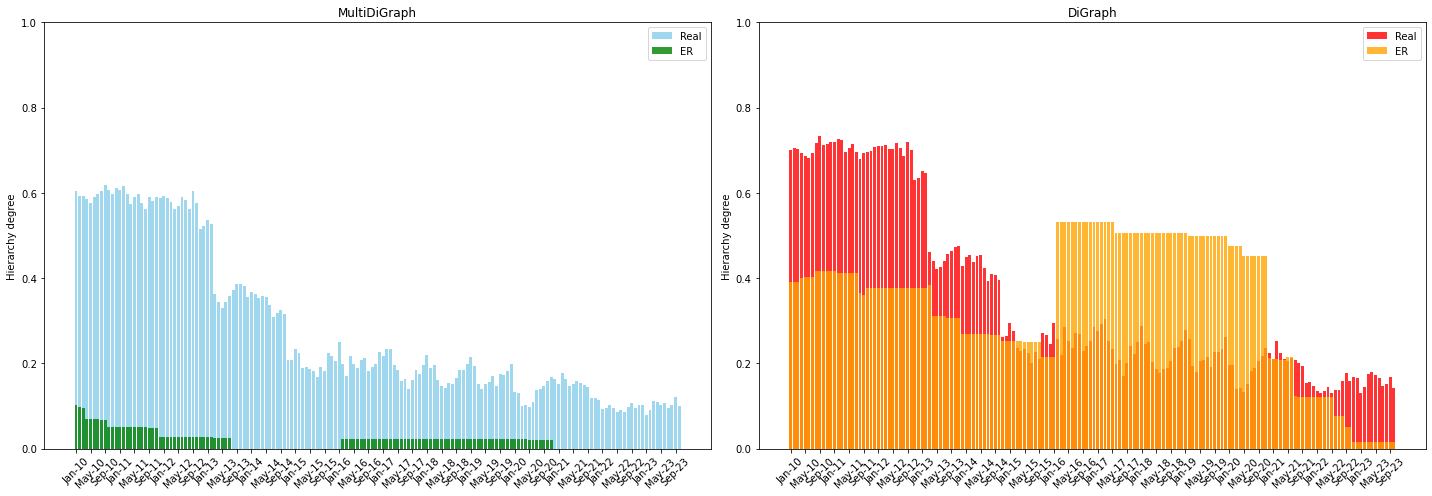

In [14]:
graph_names = [graphs[i].name for i in range(len(graphs))]
flow_hierarchy_multidigraph = [nx.flow_hierarchy(graph, weight="flow") for graph in graphs]
flow_hierarchy_digraph = [nx.flow_hierarchy(utils.create_digraph_of(graph), weight="flow") for graph in graphs]
flow_hierarchy_er_benchmark = [nx.flow_hierarchy(utils.ER_benchmark(graph)) for graph in graphs]
flow_hierarchy_er_benchmark_digraph = [nx.flow_hierarchy(utils.ER_benchmark(utils.create_digraph_of(graph))) for graph in graphs]

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs[0].bar(graph_names, flow_hierarchy_multidigraph, label='Real', color='skyblue', alpha=0.8)
axs[0].bar(graph_names, flow_hierarchy_er_benchmark, label='ER', color='green', alpha=0.8)
axs[0].set_ylabel('Hierarchy degree')
axs[0].set_title('MultiDiGraph')
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].set_xticks(range(0, len(graph_names), 4))
axs[0].set_xticklabels(graph_names[::4], rotation=45, fontsize=10)

axs[1].bar(graph_names, flow_hierarchy_digraph, label='Real', color='red', alpha=0.8)
axs[1].bar(graph_names, flow_hierarchy_er_benchmark_digraph, label='ER', color='orange', alpha=0.8)
axs[1].set_ylabel('Hierarchy degree')
axs[1].set_title('DiGraph')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].set_xticks(range(0, len(graph_names), 4))
axs[1].set_xticklabels(graph_names[::4], rotation=45, fontsize=10)


plt.tight_layout()

plt.show()


## Max flow

In [15]:
# Define sources and sinks
sources = ['Algeria', 'Russia', 'Norway', 'Liquefied Natural Gas']
sinks = ['Germany', 'France', 'Italy']

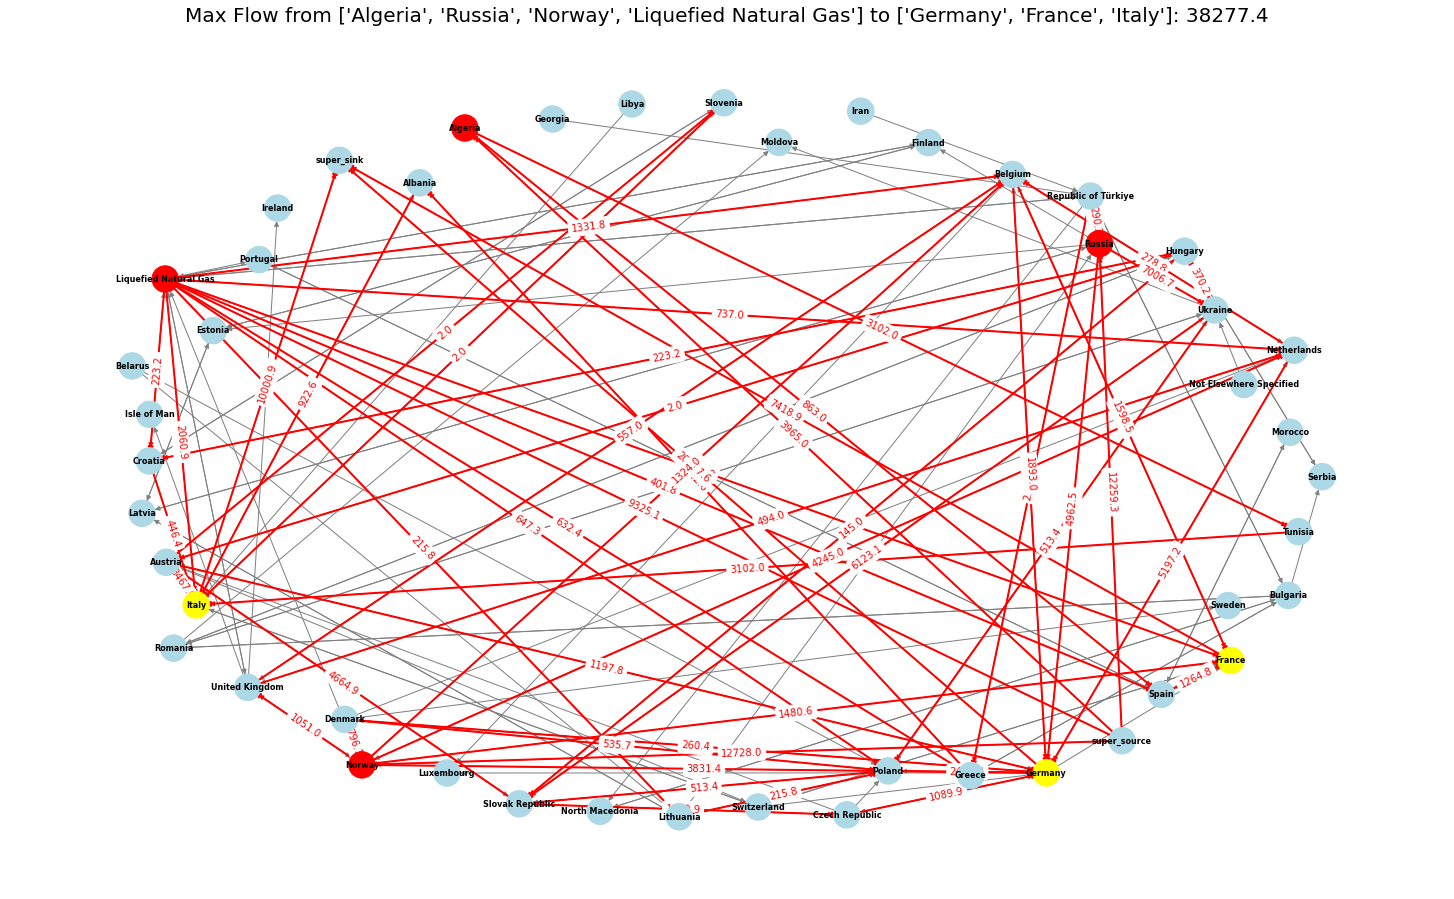

In [16]:
# Illustrative example
flow_value, flow_dict, flow_edges = utils.max_flow(oct_23_digraph, sources, sinks, capacity='capacity', show_plot=True)

### Explore load rate across MM-YYYY

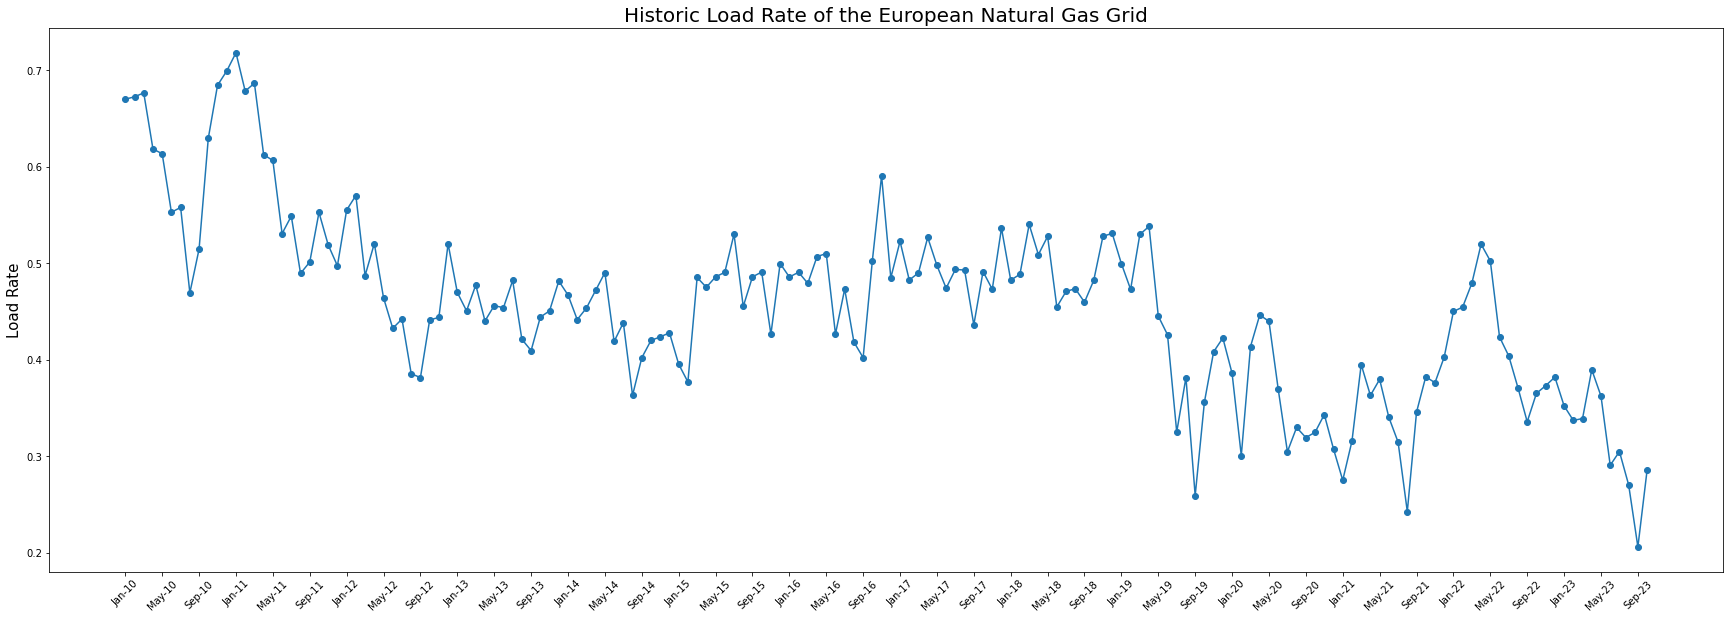

In [33]:
load_rates = []
for graph_data in graphs:
    graph = create_digraph_of(graph_data)
    
    # Calculate ideal and real flow values
    ideal_flow_value, _, _ = utils.max_flow(graph, sources, sinks, capacity='capacity', show_plot=False)
    real_flow_value, _, _ = utils.max_flow(graph, sources, sinks, capacity='flow', show_plot=False)

    # Calculate and append the load rate to the list
    load_rate = real_flow_value / ideal_flow_value
    load_rates.append(load_rate)

# Plotting
graph_names = [graphs[i].name for i in range(len(graphs))]
plt.figure(figsize=(30, 10))
plt.plot(load_rates, marker='o')
plt.ylabel('Load Rate', fontsize=15)
plt.title('Historic Load Rate of the European Natural Gas Grid', fontsize=20)
plt.xticks(range(0, len(graph_names), 4), [graph_names[i] for i in range(0, len(graph_names), 4)], rotation=45)
plt.show()
